In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

from  utils.run_foraging_testbed import run_sessions_parallel, para_scan
from utils.foraging_testbed_models import BanditRestless, Bandit

n_worker = int(mp.cpu_count())  # Optimal number = number of physical cores
pool = mp.Pool(processes = n_worker)

apply_async: 100%|██████████| 500/500 [00:02<00:00, 210.78it/s]


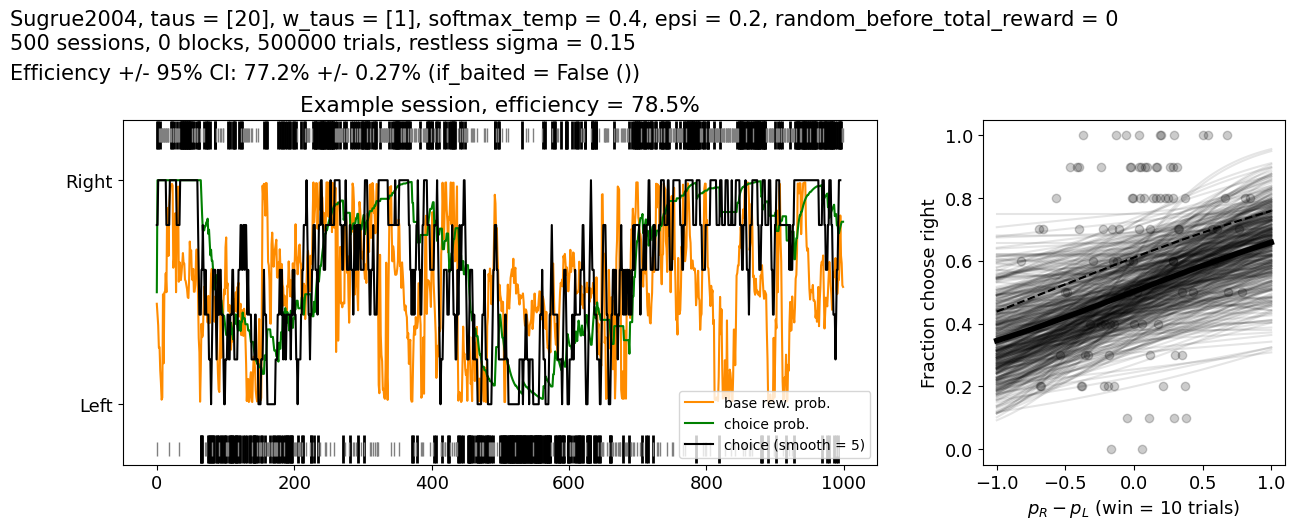

In [20]:
bandit = BanditRestless(forager='Sugrue2004',  epsilon = 0.2,  step_sizes = [0.2, 0.1], forget_rate = 0.05, softmax_temperature = 0.4, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=500, pool=pool)

apply_async: 100%|██████████| 20000/20000 [01:35<00:00, 209.04it/s]


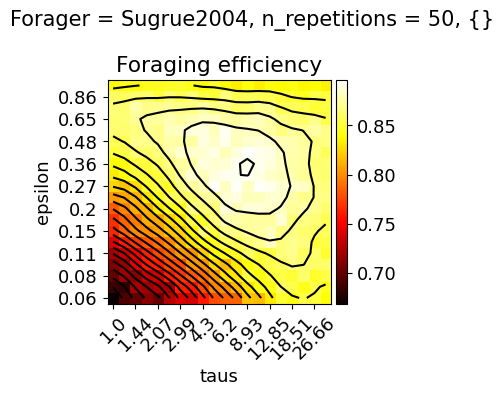

In [21]:
para_scan(forager='Sugrue2004', 
          task='Bandit_block',
          para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                         'epsilon': np.power(2, np.linspace(-4,0,20))}, 
          n_reps=50, pool=pool);

Restless bandit, `sigma = 0.15`

apply_async: 100%|██████████| 20000/20000 [01:27<00:00, 227.94it/s]


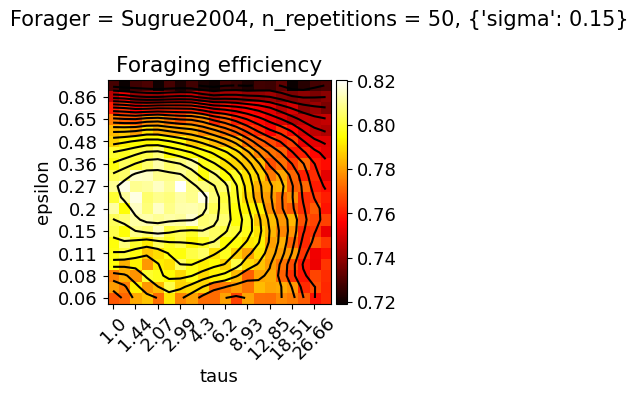

In [22]:
results_para_scan = para_scan(forager='Sugrue2004', 
                   task='Bandit_restless',
                   sigma=0.15,
                   para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                                'epsilon': np.power(2, np.linspace(-4,0,20))}, 
                   n_reps=50, pool=pool)

apply_async: 100%|██████████| 100/100 [00:00<00:00, 190.72it/s]


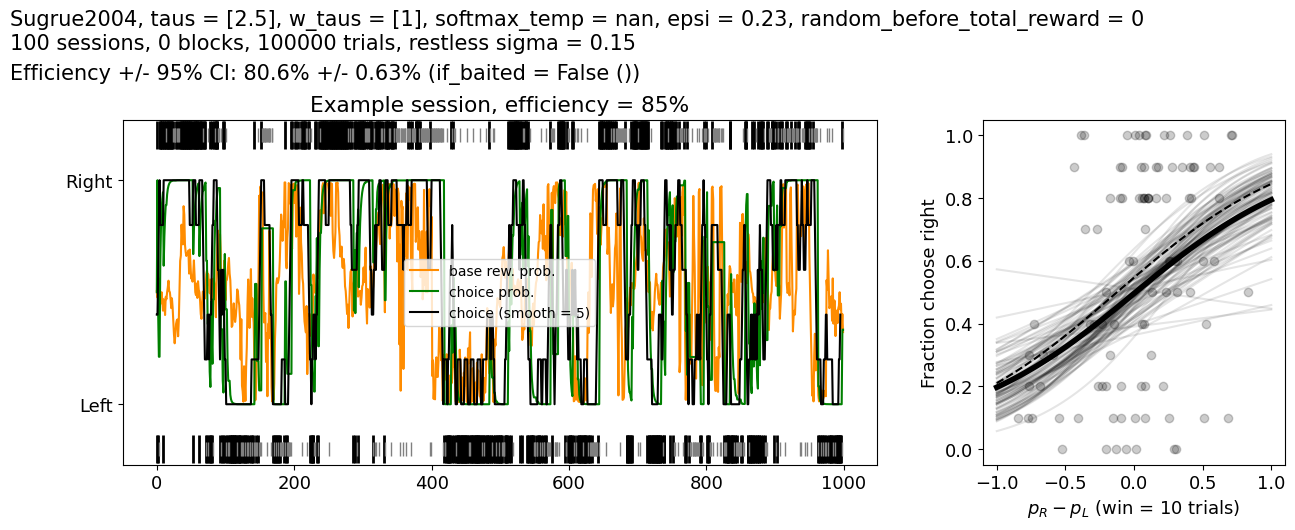

In [23]:
bandit = BanditRestless(forager='Sugrue2004',  
                        sigma=0.15,
                        epsilon=0.23,  
                        taus=2.5, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=100, pool=pool)

Restless bandit, `sigma = 0.08`

apply_async: 100%|██████████| 20000/20000 [01:27<00:00, 228.09it/s]


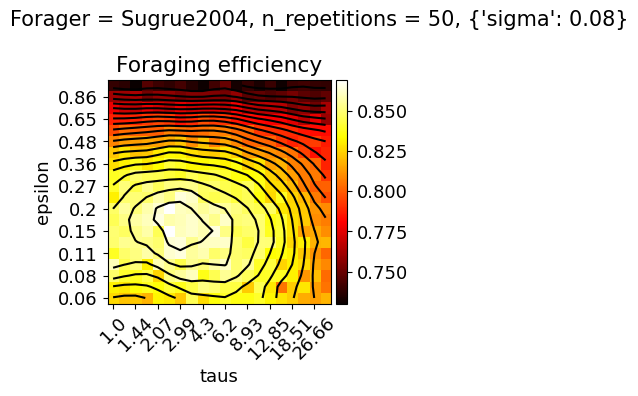

In [24]:
results_para_scan = para_scan(forager='Sugrue2004', 
                   task='Bandit_restless',
                   sigma=0.08,
                   para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                                'epsilon': np.power(2, np.linspace(-4,0,20))}, 
                   n_reps=50, pool=pool)

apply_async: 100%|██████████| 100/100 [00:00<00:00, 194.73it/s]


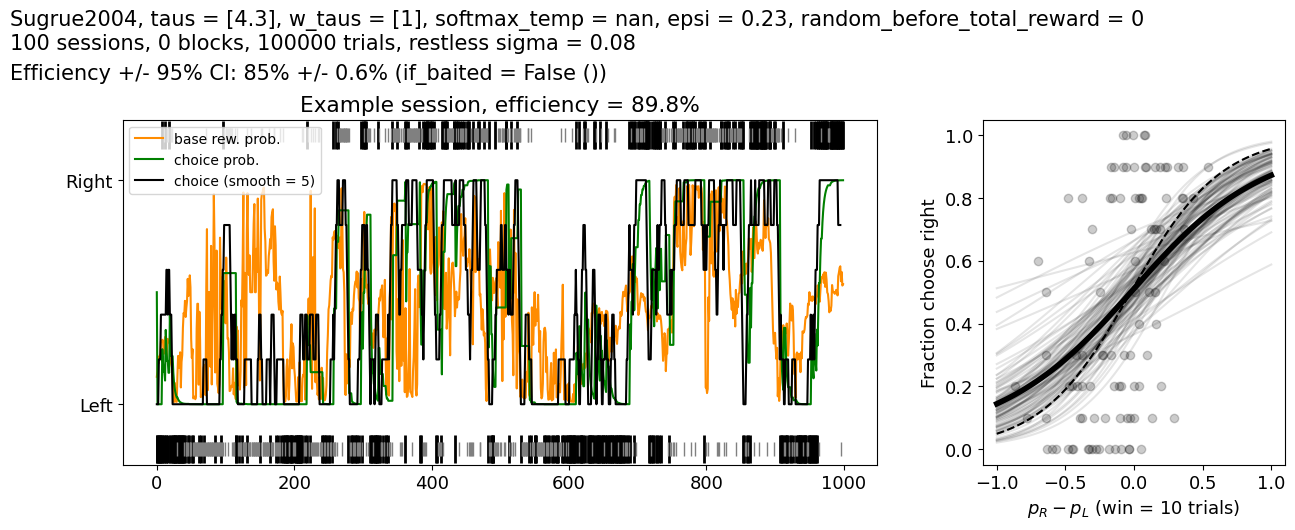

In [25]:
bandit = BanditRestless(forager='Sugrue2004', 
                        sigma=0.08, 
                        epsilon=0.23,  
                        taus=4.3, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=100, pool=pool)

apply_async: 100%|██████████| 20000/20000 [01:28<00:00, 226.59it/s]


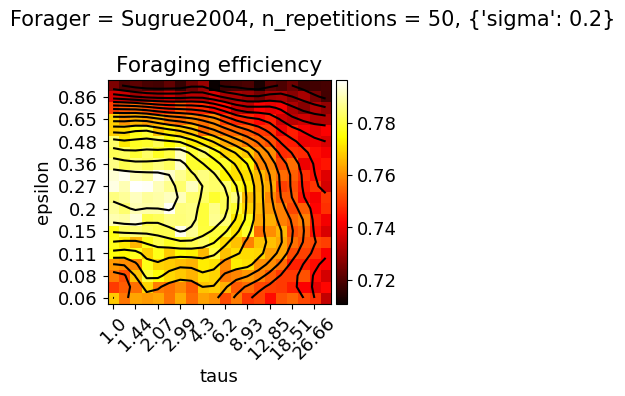

In [19]:
results_para_scan = para_scan(forager='Sugrue2004', 
                   task='Bandit_restless',
                   sigma=0.20,
                   para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                                'epsilon': np.power(2, np.linspace(-4,0,20))}, 
                   n_reps=50, pool=pool)

apply_async: 100%|██████████| 100/100 [00:00<00:00, 194.83it/s]


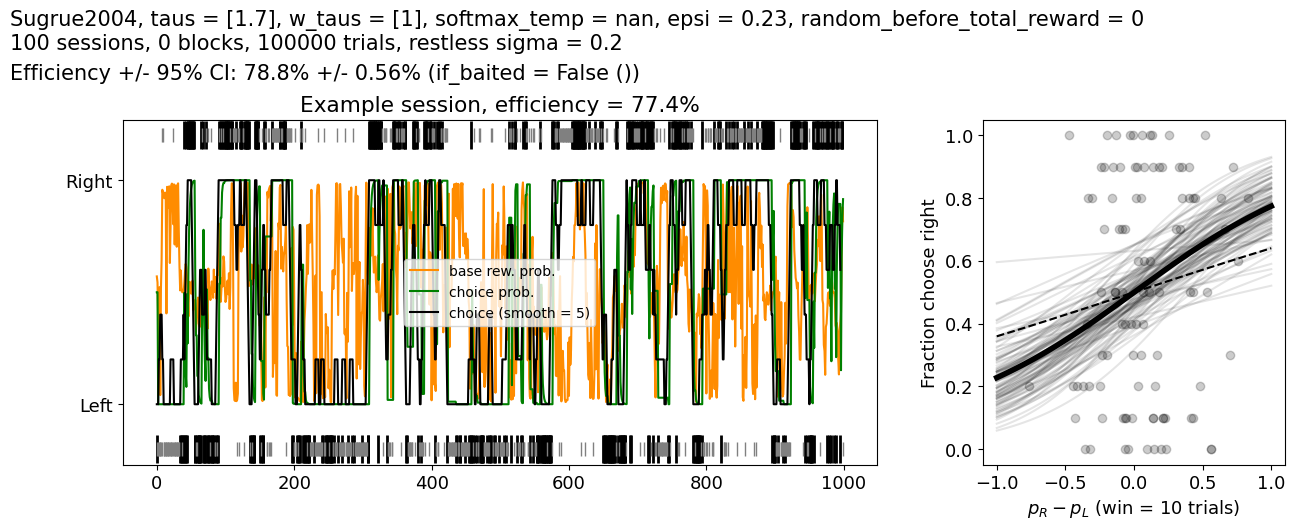

In [9]:
bandit = BanditRestless(forager='Sugrue2004', 
                        sigma=0.20, 
                        epsilon=0.23,  
                        taus=1.7, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=100, pool=pool)

[Text(0.5, 0, '$p_R - p_L$ (win = 10 trials)'),
 Text(0, 0.5, 'Fraction choose right')]

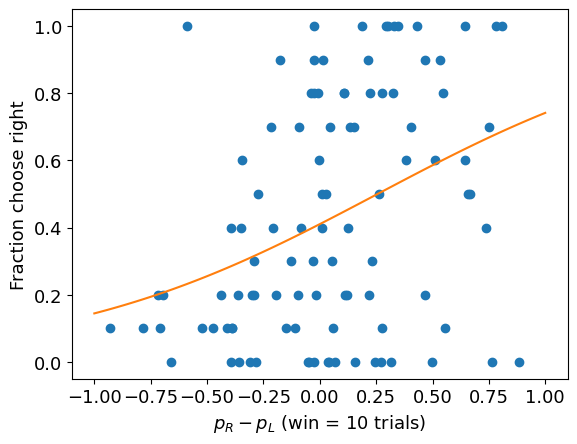

In [126]:
from scipy.optimize import curve_fit

def sigmoid(x, x0, k, a, b):
    y = a / (1 + np.exp(-k * (x - x0))) + b
    return y


def fit_sigmoid_p_choice(p_reward, choice, win=10, stepsize=None):
    if stepsize is None: stepsize = win
    start_trial = 0
    mean_p_diff = []
    mean_choice_R_frac = []

    while start_trial + win <= len(choice):
        end_trial = start_trial + win
        
        mean_p_diff.append(np.mean(np.diff(p_reward[:, start_trial:end_trial], axis=0)))
        mean_choice_R_frac.append(np.sum(choice[start_trial:end_trial] == 1) / win)
        
        start_trial += stepsize
        
    mean_p_diff = np.array(mean_p_diff)
    mean_choice_R_frac = np.array(mean_choice_R_frac)


    p0 = [0, 1, 1, 0]

    popt, pcov = curve_fit(lambda x, x0, k: sigmoid(x, x0, k, a=1, b=0), 
                        mean_p_diff, 
                        mean_choice_R_frac, 
                        # p0[:2], 
                        method='lm')
    
    return popt, pcov, mean_p_diff, mean_choice_R_frac

popt, _, mean_p_diff, mean_choice_R_frac = fit_sigmoid_p_choice(p_reward, choice, win=10)

fig, ax = plt.subplots()
xx = np.linspace(-1, 1, 100)
yy = sigmoid(xx, *popt, a=1, b=0)

ax.plot(mean_p_diff, mean_choice_R_frac, 'o')
ax.plot(xx, yy, '-')
ax.set(xlabel=f'$p_R - p_L$ (win = {win} trials)', ylabel='Fraction choose right')

    
